In [1]:
import torch
from torch import nn

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##1. Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

#Setup a path to data folder
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

#If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

#Download pizza steak and sushi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

  # Unzip file
  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


##2. Becoming one with the data (Data preparation and exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [6]:
# Setup training and test_paths
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image



Random image path: data/pizza_steak_sushi/train/steak/234626.jpg
Image class: steak
Image height: 512
Image width: 384


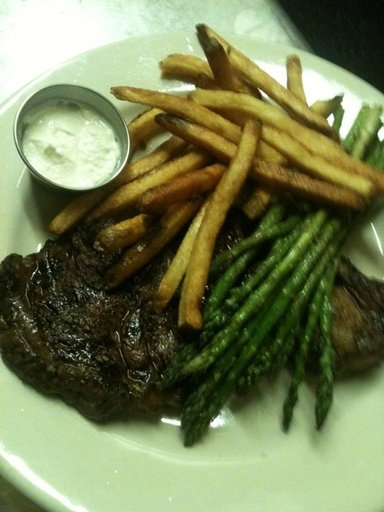

In [7]:
import random
from PIL import Image

#Set seed
random.seed(42)

# 1. Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path=random.choice(image_path_list)

# 3. Get image class from the path name (the image class is the name of the directory where the image is stored)
image_class=random_image_path.parent.stem

# 4. Open image
img=Image.open(random_image_path)

# 5. Print metadata
print("\n")
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

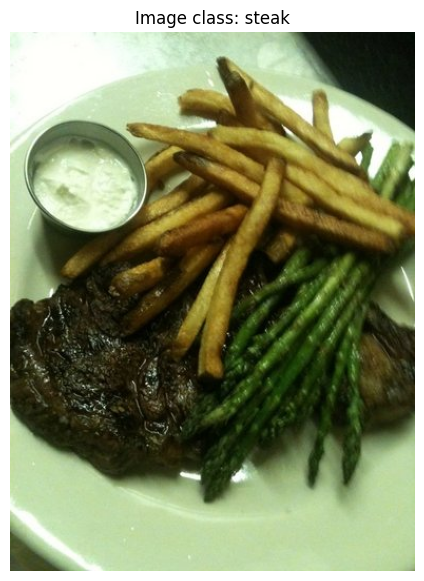

In [8]:
# Visualizing using matplotlib
import numpy as np
import matplotlib.pyplot as plt

image_as_array=np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class}")
plt.axis(False)

## 3. Transforming Data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [10]:
# Write a transform for image
data_transform=transforms.Compose(
  [
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
  ]
)

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

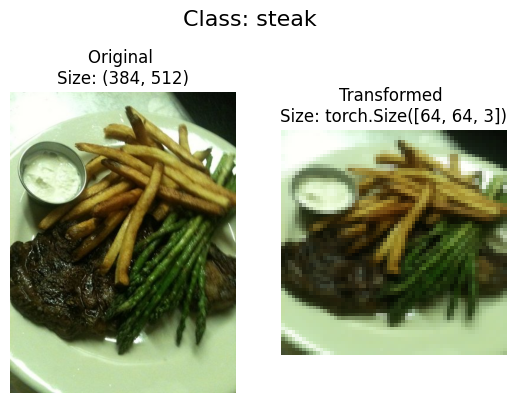

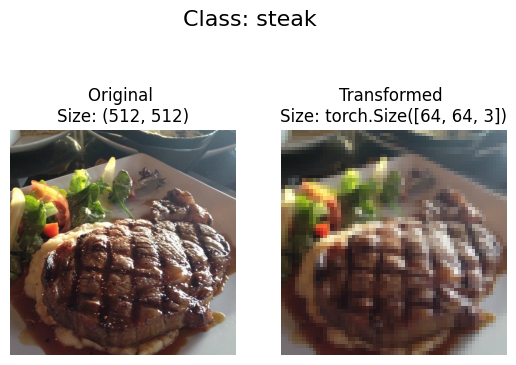

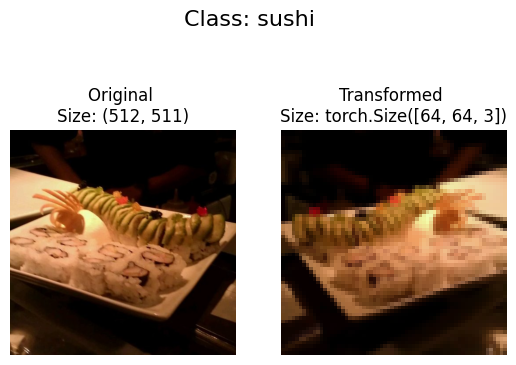

In [12]:
def plot_transformed_images(image_paths,
                            transform,
                            n=3,
                            seed=None):
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot target image
      transformed_image=transform(f).permute(1,2,0) #We will need to change shape for matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,seed=42)

## 4. Option-1: Loading Image data using ImageFolder

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform,
                                target_transform=None)

test_data= datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dictionary
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
img,label=train_data[0][0],train_data[0][1]
img,label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

Original image shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

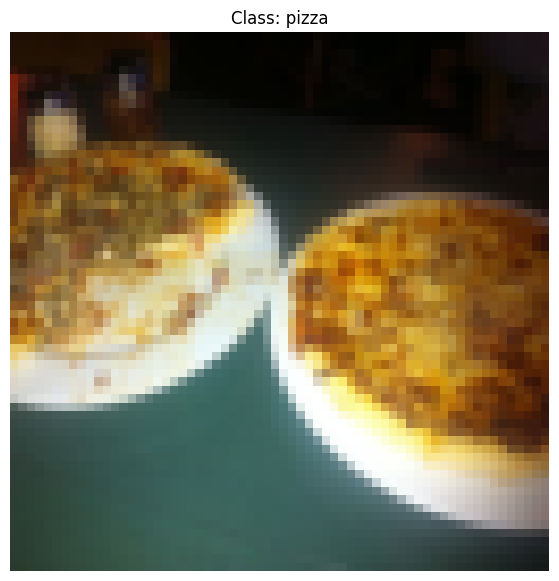

In [18]:
# Rearrang the order of dimension
img_permute=img.permute(1,2,0)

#Print out different shapes
print(f"Original image shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

#Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(f"Class: {class_names[label]}")
plt.axis("off")

### 4.1 Turn loaded image into DataLoaders

In [19]:
import os
os.cpu_count()

2

In [20]:
#Turn train & test datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=1,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x794d110df940>,
 <torch.utils.data.dataloader.DataLoader at 0x794d110dff10>)

In [21]:
img, label=next(iter(train_dataloader))

#Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


##5 Option-2: Loading Image Data with a Custom `Dataset`

In [22]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [23]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [24]:
# Setup path for target directory
target_directory=train_dir
print(target_directory)

# Get the class names from the target directory
class_names_found=sorted([entry.name for entry in os.scandir(target_directory) if entry.is_dir()])
class_names_found

data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [25]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  #1. Get the class names by scanning the target directory
  classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  #2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")
  #3. Create a dictionary of index to class
  class_to_idx={cls_name:i for i,cls_name in enumerate(classes)}
  return classes,class_to_idx

In [26]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

In [27]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [28]:
# Create a transform
train_transforms=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


In [29]:
# Test out ImageFolderCustom
train_data_custom=ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_transforms)

test_data_custom=ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)

In [30]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x794d10f07dc0>,
 <__main__.ImageFolderCustom at 0x794d10f07c70>)

In [31]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [32]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [33]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Create a function to display random images

In [34]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

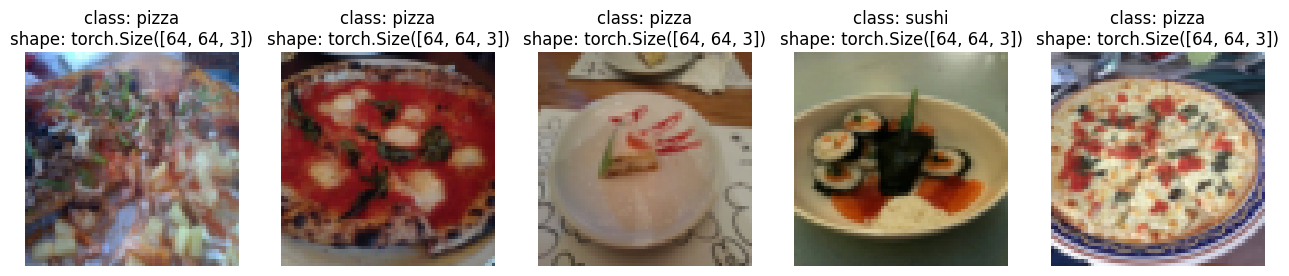

In [35]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


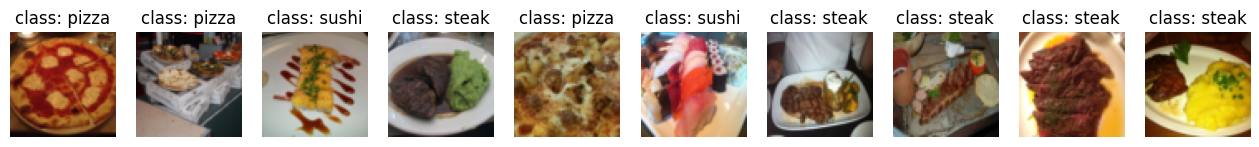

In [36]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoaders`

In [37]:
from torch.utils.data import DataLoader
BATCH_SIZE=1

train_dataloader_custom=DataLoader(dataset=train_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x794d10cf0dc0>,
 <torch.utils.data.dataloader.DataLoader at 0x794d10cf3790>)

In [38]:
# Get image and label from custom dataloader
img_custom, label_custom=next(iter(train_dataloader_custom))

#Print out shapes
print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## 6. Other forms of transforms (Data Augmentation)

In [39]:
from torchvision import transforms

train_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [40]:
# Get all the image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/2629750.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/75537.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/176508.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/735441.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614649.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1787505.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3074367.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1937872.jpg')]

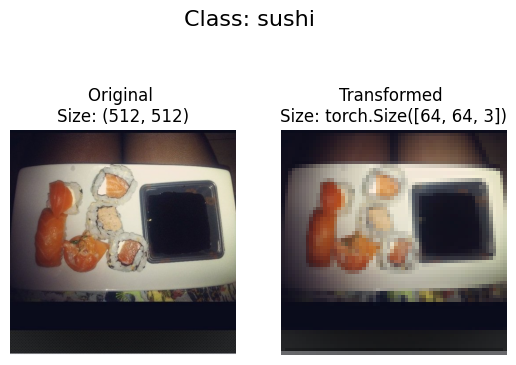

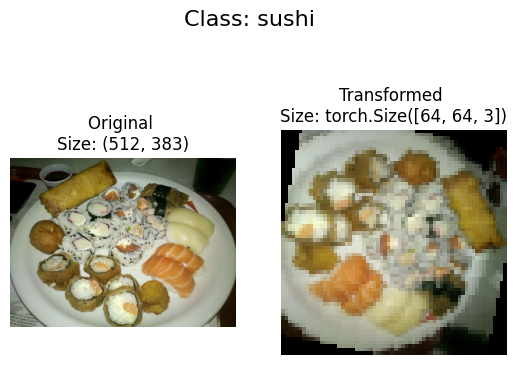

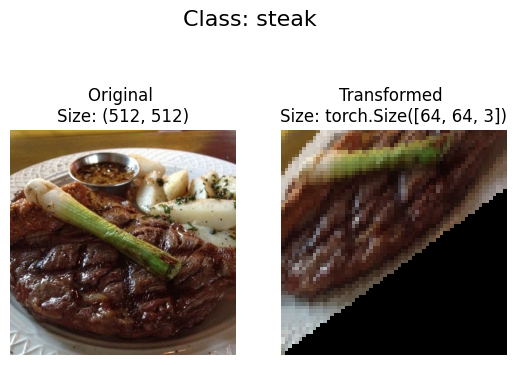

In [41]:
#Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model-0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [42]:
# Create simple transform
simple_transform=transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.ToTensor()
])

In [43]:
# 1. Load and transform data
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of workers
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

# Create DataLoaders
train_dataloader_simple= DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

test_dataloader_simple= DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG Model class

In [44]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x):
    x=self.conv_block_1(x)
    x=self.conv_block_2(x)
    x=self.classifier(x)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [45]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data_simple.classes))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (Testing)

In [46]:
# get a single image batch
image_batch, label_batch=next(iter(train_dataloader_simple))

# single image batch shape
image_batch.shape

torch.Size([32, 3, 64, 64])

In [47]:
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [48]:
pip install torchinfo

In [49]:
import torchinfo
from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loops functions

In [50]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()

  train_loss, train_acc=0,0

  #Loop through our dataloader data batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred=model(X)

    # 2. Calculate the loss
    loss=loss_fn(y_pred, y)
    train_loss+=loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
    return train_loss, train_acc

In [51]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc=0,0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits=model(X)

      # 2. Calculate the loss
      loss=loss_fn(test_pred_logits, y)
      test_loss+=loss.item()

      # Calculate accuracy metric
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)

  test_loss/=len(dataloader)
  test_acc/=len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a train() and combine train_step() & test_step()

In [52]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + Loss function

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn)

      # 4. Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # 5. Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results


### 7.7 Train and evaulate model 0

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set number of epochs
NUM_EPOCHS= 5

# Recreate instance of TinyVGG
model_0=TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_simple.classes)
)

# Setup loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001)
# Start the timer
from timeit import default_timer as timer
start_time=timer()

# Train model_0
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1002 | train_acc: 0.2500 | test_loss: 1.0864 | test_acc: 0.4223
Epoch: 2 | train_loss: 1.1128 | train_acc: 0.2812 | test_loss: 1.0884 | test_acc: 0.4025
Epoch: 3 | train_loss: 1.0824 | train_acc: 0.4688 | test_loss: 1.0811 | test_acc: 0.4223
Epoch: 4 | train_loss: 1.1338 | train_acc: 0.2500 | test_loss: 1.0866 | test_acc: 0.4223
Epoch: 5 | train_loss: 1.0686 | train_acc: 0.3438 | test_loss: 1.0842 | test_acc: 0.4223
Total training time: 9.398 seconds


In [54]:
model_0_results

{'train_loss': [1.100226879119873,
  1.1128194332122803,
  1.0824296474456787,
  1.1338223218917847,
  1.0685724020004272],
 'train_acc': [0.25, 0.28125, 0.46875, 0.25, 0.34375],
 'test_loss': [1.0863815546035767,
  1.0883605082829793,
  1.0811211268107097,
  1.0865579843521118,
  1.0841726064682007],
 'test_acc': [0.42234848484848486,
  0.40246212121212127,
  0.42234848484848486,
  0.42234848484848486,
  0.42234848484848486]}

### 7.8 Plot the loss curves of Model 0

In [55]:
def plot_loss_curves(
    results: Dict[str, List[float]]):
  # Get the loss values of the results dictionary
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  # Get the accuracy values of the results dictionary
  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  # Figure out how many epochs there were
  epochs=range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))
  #Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

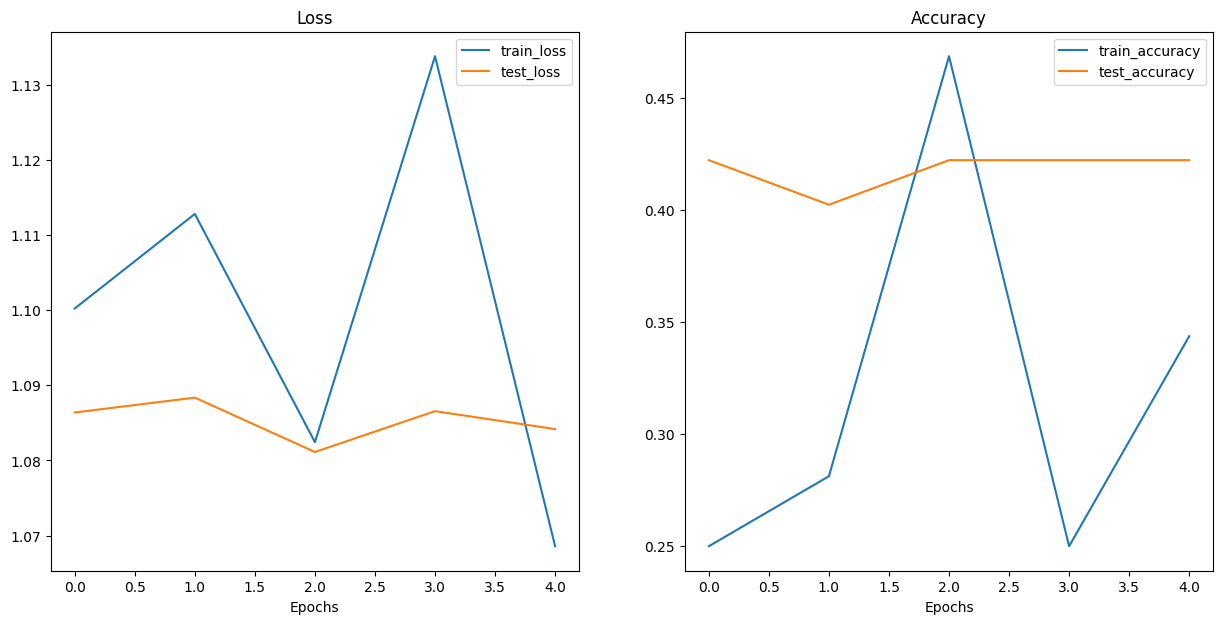

In [56]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

## 9. Model-1: TinyVGG with data augmentation

### 9.1 Create a transform with data augmentation

In [57]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset and DataLoader with data augmentation

In [58]:
# Turn image folders into Datasets
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                        transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [59]:
# Turn datasets into dataloaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of workers
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented=DataLoader(dataset=train_data_augmented,
                                       batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False)


### 9.3 Construct and train Model 1

In [60]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [61]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS= 5

# Setup loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                           lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time=timer()

# Train model_1
model_1_results=train(model=model_1,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1031 | train_acc: 0.2500 | test_loss: 1.0657 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.0894 | train_acc: 0.4062 | test_loss: 1.0432 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1061 | train_acc: 0.3125 | test_loss: 1.0373 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.1507 | train_acc: 0.2500 | test_loss: 1.0442 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.0973 | train_acc: 0.3438 | test_loss: 1.0530 | test_acc: 0.5417
Total training time: 10.724 seconds


### 9.4 Plot the loss curves of Model-1

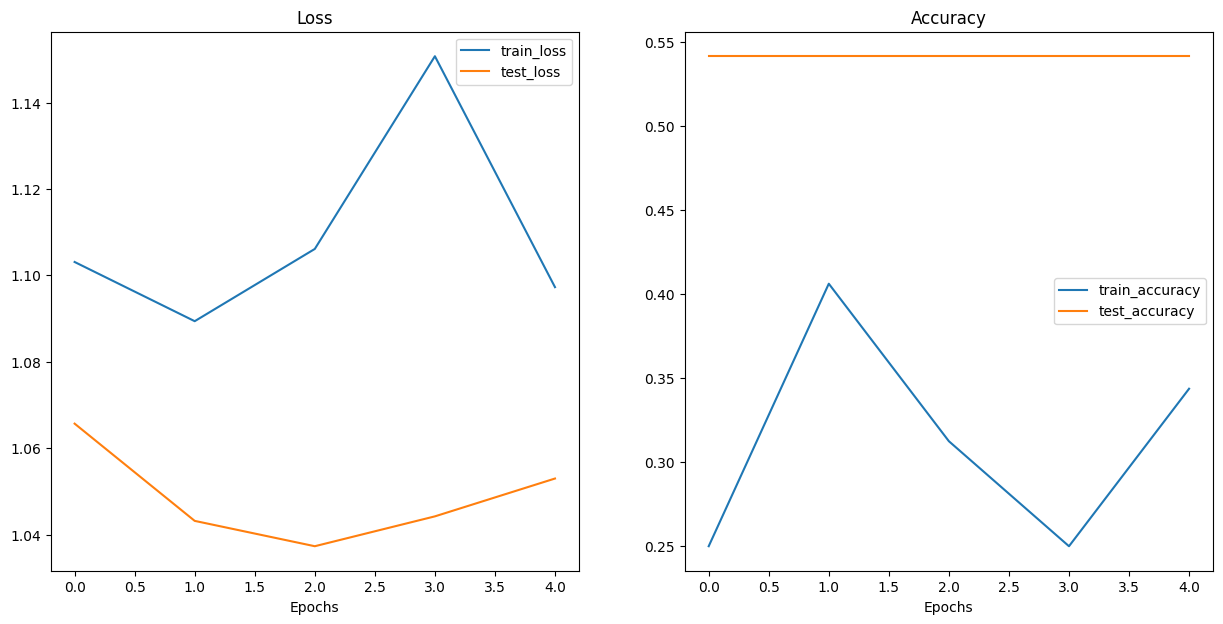

In [62]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [63]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.100227,0.25000,1.086382,0.422348
1,1.112819,0.28125,1.088361,0.402462
2,1.082430,0.46875,1.081121,0.422348
3,1.133822,0.25000,1.086558,0.422348
4,1.068572,0.34375,1.084173,0.422348


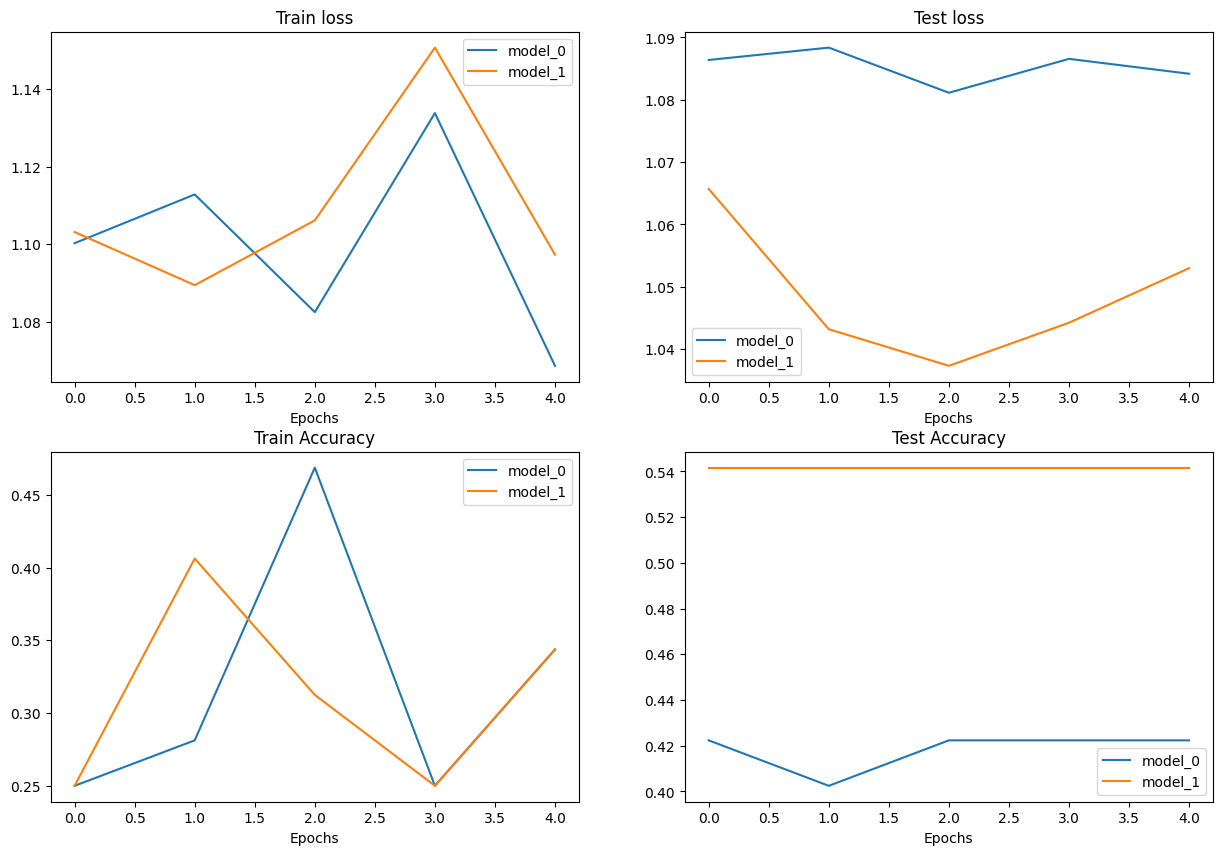

In [65]:
# Setup a plot
plt.figure(figsize=(15,10))

#get the number of epochs
epochs= range(len(model_0_df))

#Plot train Loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="model_0")
plt.plot(epochs, model_1_df["train_loss"], label="model_1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

#plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="model_0")
plt.plot(epochs, model_1_df["test_loss"], label="model_1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

#Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="model_0")
plt.plot(epochs, model_1_df["train_acc"], label="model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

#Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="model_0")
plt.plot(epochs, model_1_df["test_acc"], label="model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

In [69]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch

Make sure that custom image is in the same format as the data our model was trained on

In [111]:
import torchvision

path="/content/data/pizza-pizza-filled-with-tomatoes-salami-olives.jpg"
# Load in custom image
custom_image_uint8 = torchvision.io.read_image(str(path))

custom_image=custom_image_uint8

custom_image

tensor([[[111, 121, 118,  ..., 102,  93,  92],
         [118, 149, 128,  ...,  97,  93,  96],
         [160, 171, 146,  ...,  67,  66,  68],
         ...,
         [159, 155, 155,  ..., 129, 134, 135],
         [164, 153, 156,  ..., 136, 139, 138],
         [189, 172, 160,  ..., 124, 124, 121]],

        [[103, 101, 100,  ...,  75,  69,  63],
         [102, 125, 112,  ...,  75,  70,  69],
         [145, 160, 133,  ...,  60,  55,  55],
         ...,
         [124, 124, 124,  ...,  89,  92,  93],
         [130, 125, 128,  ...,  91,  92,  90],
         [147, 139, 129,  ...,  87,  85,  80]],

        [[ 92,  92,  90,  ...,  64,  59,  57],
         [102, 113,  96,  ...,  64,  62,  62],
         [142, 142, 114,  ...,  52,  49,  47],
         ...,
         [102, 103, 103,  ...,  64,  70,  71],
         [105, 104, 104,  ...,  72,  74,  70],
         [122, 120, 108,  ...,  71,  68,  62]]], dtype=torch.uint8)

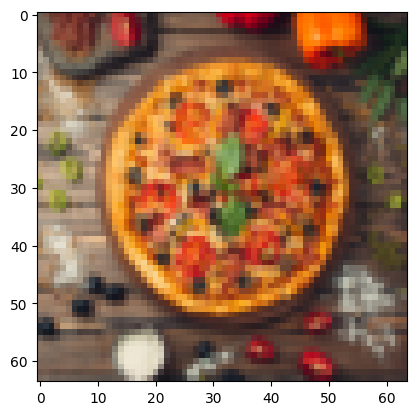

In [98]:
plt.imshow(custom_image_transformed.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained PyTorch Model

In [112]:
import torchvision
custom_image=torchvision.io.read_image(str(path)).type(torch.float32)/255
custom_image

tensor([[[0.4353, 0.4745, 0.4627,  ..., 0.4000, 0.3647, 0.3608],
         [0.4627, 0.5843, 0.5020,  ..., 0.3804, 0.3647, 0.3765],
         [0.6275, 0.6706, 0.5725,  ..., 0.2627, 0.2588, 0.2667],
         ...,
         [0.6235, 0.6078, 0.6078,  ..., 0.5059, 0.5255, 0.5294],
         [0.6431, 0.6000, 0.6118,  ..., 0.5333, 0.5451, 0.5412],
         [0.7412, 0.6745, 0.6275,  ..., 0.4863, 0.4863, 0.4745]],

        [[0.4039, 0.3961, 0.3922,  ..., 0.2941, 0.2706, 0.2471],
         [0.4000, 0.4902, 0.4392,  ..., 0.2941, 0.2745, 0.2706],
         [0.5686, 0.6275, 0.5216,  ..., 0.2353, 0.2157, 0.2157],
         ...,
         [0.4863, 0.4863, 0.4863,  ..., 0.3490, 0.3608, 0.3647],
         [0.5098, 0.4902, 0.5020,  ..., 0.3569, 0.3608, 0.3529],
         [0.5765, 0.5451, 0.5059,  ..., 0.3412, 0.3333, 0.3137]],

        [[0.3608, 0.3608, 0.3529,  ..., 0.2510, 0.2314, 0.2235],
         [0.4000, 0.4431, 0.3765,  ..., 0.2510, 0.2431, 0.2431],
         [0.5569, 0.5569, 0.4471,  ..., 0.2039, 0.1922, 0.

In [94]:
custom_image.shape

torch.Size([3, 2759, 2916])

In [113]:
# Create a transform pipeline to resize image
from torchvision import transforms
custom_image_transform=transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed=custom_image_transform(custom_image)

print(f"Original image shape: {custom_image.shape}")
print(f"Transformed image shape: {custom_image_transformed.shape}")

Original image shape: torch.Size([3, 2759, 2916])
Transformed image shape: torch.Size([3, 64, 64])


In [114]:
# Try to make a prediction on an image
model_1.eval()
with torch.inference_mode():
    custom_image_pred=model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
custom_image_pred

tensor([[ 0.0961, -0.2178,  0.1777]])

In [101]:
class_names

['pizza', 'steak', 'sushi']

In [115]:
# Convert logits -> pred probs
custom_image_pred_probs=torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3552, 0.2595, 0.3854]])

In [116]:
# Convert pred probs -> pred labels
custom_image_pred_label=torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([2])

In [109]:
class_names[custom_image_pred_label]

'sushi'

### 11.3 Putting custom image prediction together: building a function

In [119]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

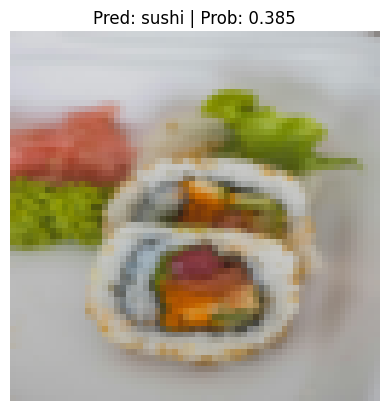

In [125]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path="/content/data/pexels-valeriya-1052189.jpg",
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)